<a href="https://colab.research.google.com/github/pewitwit/nih-chest-x-rays/blob/main/%D0%A1%D1%82%D1%80%D1%83%D0%BA%D1%82%D1%83%D1%80%D0%B0_dataton_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обработка изображений цифровой рентгенографии органов грудной клетки методами компьютерного зрения

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload() #upload kaggle.json with login and key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"katayevanatalia","key":"fed0cc401c2c644b058d95bf2c9f51b5"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# импорт библиотек
import cv2
import glob
import io
import kaggle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np
import opendatasets as od
import os
import shutil
import pandas as pd
import random
import requests
import seaborn as sns
import tensorflow as tf

from collections import OrderedDict
from io import StringIO, BytesIO
from PIL import Image, ImageEnhance, ImageFilter
from scipy import stats as st


## Изучение датасета

In [ ]:
data = od.download(
    "https://www.kaggle.com/datasets/nih-chest-xrays/data?select=Data_Entry_2017.csv")

100%|██████████| 42.0G/42.0G [03:38<00:00, 206MB/s]


In [ ]:
# загрузка данных
try:
    data = pd.read_csv('/content/data/Data_Entry_2017.csv')
except:
    print("Ошибка загрузки файла")

In [ ]:
# изучение датасета
data.info()
display(data.head(10)) 
display(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


,count,mean,std,min,25%,50%,75%,max
Follow-up #,112120.0,8.573751,15.406320,0.000,0.000,3.000,10.000,183.0000
Patient ID,112120.0,14346.381743,8403.876972,1.000,7310.750,13993.000,20673.000,30805.0000
Patient Age,112120.0,46.901463,16.839923,1.000,35.000,49.000,59.000,414.0000
OriginalImage[Width,112120.0,2646.078844,341.246429,1143.000,2500.000,2518.000,2992.000,3827.0000
Height],112120.0,2486.438842,401.268227,966.000,2048.000,2544.000,2991.000,4715.0000
OriginalImagePixelSpacing[x,112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
y],112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
Unnamed: 11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Наблюдения**

*   Всего в представленном датасете 112 120 наблюдений и 12 признаков.
*   Последняя колонка (Unnamed: 11) содержит только null-значения. Остальные 11 колонок не содержат ни одного null-значения.
*   Названия признаков выглядят “непитонично” - пишутся с большой буквы.
*   В признаке Patient Age есть выбросы в виде слишком большого возраста (максимальное значение = 414).
*   Признак "Finding Labels" содержит в себе как одиночные названия патологий, так и их комбинации.

In [ ]:
# удаляем пустой столбец
data = data.drop('Unnamed: 11', axis=1)

In [ ]:
# обработка названий столбцов
data.columns = map(str.lower, data.columns)

In [ ]:
# поиск пропусков и явных дубликатов
display(data.isna().sum())
display(data.duplicated().sum())

image index                    0
finding labels                 0
follow-up #                    0
patient id                     0
patient age                    0
patient gender                 0
view position                  0
originalimage[width            0
height]                        0
originalimagepixelspacing[x    0
y]                             0
dtype: int64

0

**Наблюдения**

*   Пропусков в первых 11 колонках не имеется.
*   Явных дубликатов так же не имеется.

'Коэффициенты корреляции:'

,follow-up #,patient id,patient age,originalimage[width,height],originalimagepixelspacing[x,y]
follow-up #,1.000000,-0.026528,-0.028684,0.039551,-0.127636,0.017533,0.017533
patient id,-0.026528,1.000000,-0.041084,0.222263,0.193855,-0.218915,-0.218915
patient age,-0.028684,-0.041084,1.000000,0.087670,0.016914,0.002522,0.002522
originalimage[width,0.039551,0.222263,0.087670,1.000000,0.587006,-0.832195,-0.832195
height],-0.127636,0.193855,0.016914,0.587006,1.000000,-0.797572,-0.797572
originalimagepixelspacing[x,0.017533,-0.218915,0.002522,-0.832195,-0.797572,1.000000,1.000000
y],0.017533,-0.218915,0.002522,-0.832195,-0.797572,1.000000,1.000000


                             follow-up #  patient id  patient age  \
follow-up #                     1.000000   -0.026528    -0.028684   
patient id                     -0.026528    1.000000    -0.041084   
patient age                    -0.028684   -0.041084     1.000000   
originalimage[width             0.039551    0.222263     0.087670   
height]                        -0.127636    0.193855     0.016914   
originalimagepixelspacing[x     0.017533   -0.218915     0.002522   
y]                              0.017533   -0.218915     0.002522   

                             originalimage[width   height]  \
follow-up #                             0.039551 -0.127636   
patient id                              0.222263  0.193855   
patient age                             0.087670  0.016914   
originalimage[width                     1.000000  0.587006   
height]                                 0.587006  1.000000   
originalimagepixelspacing[x            -0.832195 -0.797572   
y]           

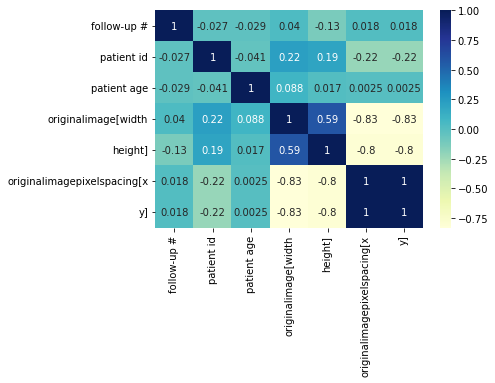

In [ ]:
#считаем корреляцию
display('Коэффициенты корреляции:', data.corr())

print(data.corr())
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

**Наблюдения**

*   Скорррелированными признаками являются только те, которые обозначают параметры изображения (признаки "originalimage[width", "height]", "originalimagepixelspacing[x", "y]").

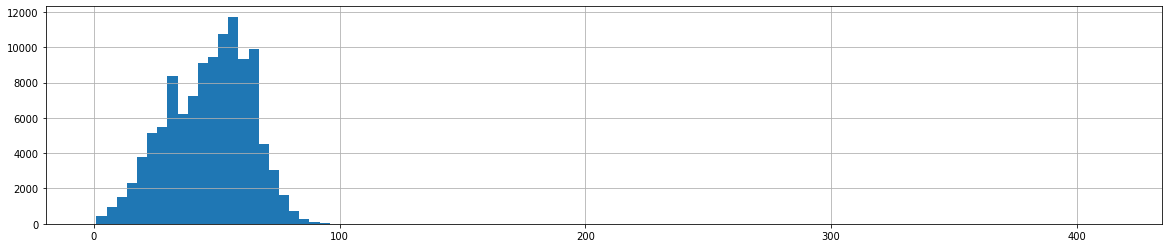

In [ ]:
plt.figure(figsize=(20, 4))
data['patient age'].hist(bins=100)

**Наблюдения**

*   На графике изображено нормальное распределение наблюдений по возрасту с левосторонней асимметрией.
*   Из-за наличия выбросов график имеет длинный, но неразличимый хвост справа.

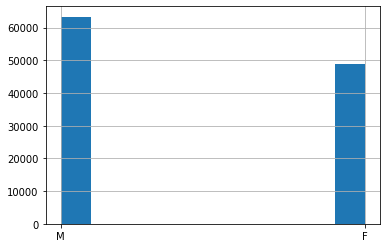

In [ ]:
data['patient gender'].hist()

**Наблюдения**

*   В распределении по полу наблюдается больше снимков пациентов мужского пола.

### Выводы

*   Датасет имеет более 100 тысяч наблюдений.
*   Датасет не имеет пропущенных значений или дубликатов. Единственный столбец, состоящий полностью из null-значений, был удален.
*   По признаку "возраст пациента" наблюдаются выбросы со значениями до 414, которые впоследствие будут отброшены. В целом этот признак имеет нормальное распределение с левосторонней асимметрией.
*   Признак "Finding Labels" содержит строковый тип данных, что приводит к необходимости кодирования этих категорий в дальнейшем анализе.

## Изучение изображений

In [ ]:
img_folder = r'/content/data/images_001/images'

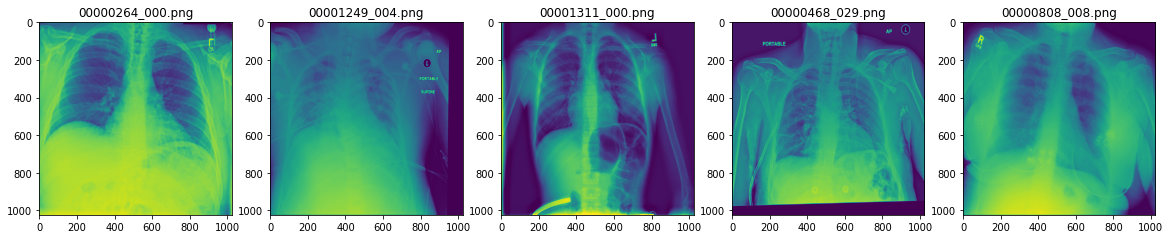

In [ ]:
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Исследовательский анализ данных

Для работы с распределениями по типу патологии необходимо провести кодирование признака "finding labels".

In [ ]:
# создаем список с названиями всех уникальных лейблов
labels_list = data['finding labels'].unique()
uniq_labels_list = [*filter(lambda x: '|' not in x, labels_list)]

# создаем таблицу с лейблами, заполненную нулями
empty_dum = pd.DataFrame(np.zeros(
    (
    data.shape[0], len(uniq_labels_list))
    )
).astype('int')
column_names = {el:lab for el, lab in zip(
    range(len(uniq_labels_list)
    ), uniq_labels_list)}
empty_dum = empty_dum.rename(columns=column_names)

# кодирование для уникальных лейблов
data_encod = data.copy()
data_encod = pd.concat([data_encod, empty_dum], axis=1)
for n in range(data_encod.shape[0]):
    row_label = data_encod.loc[n]['finding labels']
    if '|' in row_label:
        multi_label = row_label.split('|')
        for label in multi_label:
            data_encod[label].loc[n] = 1
    else:
        data_encod[row_label].loc[n] = 1
data_encod.drop(columns=['originalimage[width',
                         'height]',
                         'originalimagepixelspacing[x',
                         'y]'])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,image index,finding labels,follow-up #,patient id,patient age,patient gender,view position,Cardiomegaly,No Finding,Hernia,...,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,0,0,0,...,0,0,0,0,0,1,0,0,0,1
112116,00030802_000.png,No Finding,0,30802,29,M,PA,0,1,0,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,0,1,0,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = data_encod.copy()

Также необходимо избавиться от выбросов по признаку возраста пациента.

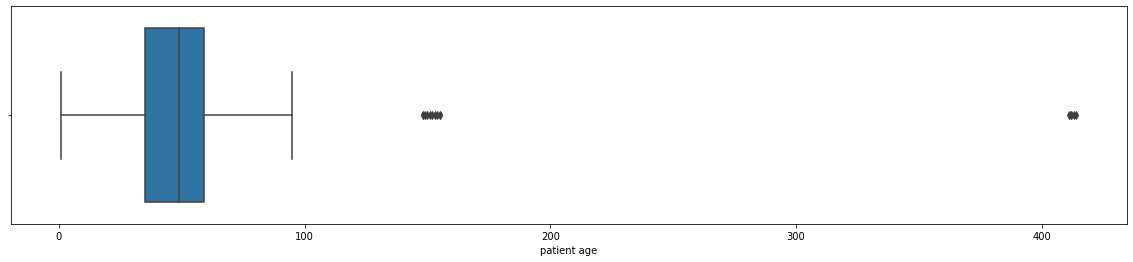

In [ ]:
# строим boxplot по признаку возраста для визуализации выбросов
plt.figure(figsize=(20, 4))
sns.boxplot(x=data['patient age'])

Исходя из соображений логики, удаляем наблюдения, где возраст пациента > 120 лет.

In [ ]:
# удаляем выбросы по возрасту
outliers = data[data['patient age'] > 120]
cleaned = data.drop(outliers.index, axis=0)
print('Количество выбросов по возрасту:', data.shape[0] - cleaned.shape[0])

Количество выбросов по возрасту: 16


In [ ]:
data = cleaned.copy()

In [ ]:
# посмотрим на самые частые лейблы
uniq_labels_dict = {lab:0 for lab in uniq_labels_list}
for label in uniq_labels_list:
    uniq_labels_dict[label] = sum(data.loc[:, label])

most_common = pd.DataFrame(uniq_labels_dict.items(), columns=['label', 'count'])
most_common = most_common.sort_values(by='count', ascending=False)
print(most_common)
print(most_common.info())

                 label  count
1           No Finding  60353
3         Infiltration  19891
6             Effusion  13316
7          Atelectasis  11558
4               Nodule   6331
10                Mass   5779
9         Pneumothorax   5301
12       Consolidation   4667
8   Pleural_Thickening   3384
0         Cardiomegaly   2776
5            Emphysema   2516
13               Edema   2302
11            Fibrosis   1686
14           Pneumonia   1430
2               Hernia    227
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 1 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   15 non-null     object
 1   count   15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 360.0+ bytes
None


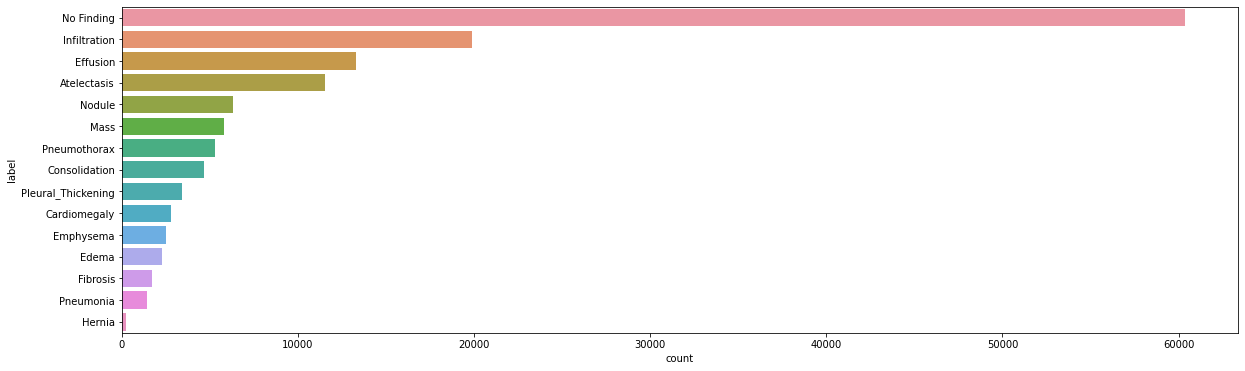

In [ ]:
fig, ay = plt.subplots(figsize=(20, 6))
sns.barplot(data=most_common, y=most_common['label'], x=most_common['count'])

Infiltration                9547
Atelectasis                 4215
Effusion                    3955
Nodule                      2705
Pneumothorax                2194
Mass                        2139
Effusion|Infiltration       1603
Atelectasis|Infiltration    1350
Consolidation               1310
Atelectasis|Effusion        1165
Name: finding labels, dtype: int64


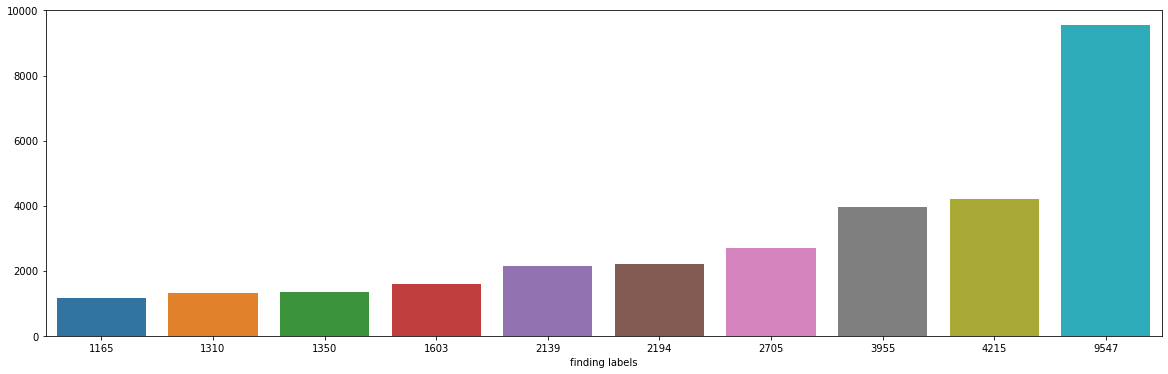

In [ ]:
# больше всего здоровых людей, посмотрим распределение без них
common_patology = ((data[data['finding labels'] != "No Finding"])['finding labels']
                  .value_counts()
                  .sort_values(ascending=False)[:10])
print(common_patology)

fig, ay = plt.subplots(figsize=(20, 6))
sns.barplot(data=common_patology, y=common_patology.values, x=common_patology.index)

In [ ]:
common_labels = list(most_common.index)

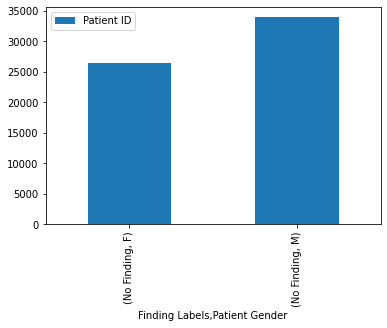

Patient ID
Finding Labels Patient Gender            
No Finding     F                    26439
               M                    33922

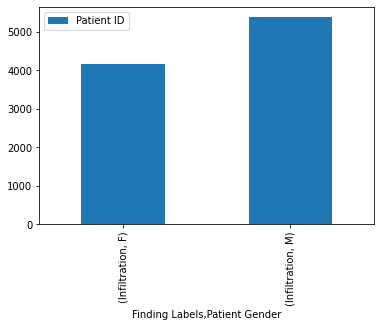

Patient ID
Finding Labels Patient Gender            
Infiltration   F                     4164
               M                     5383

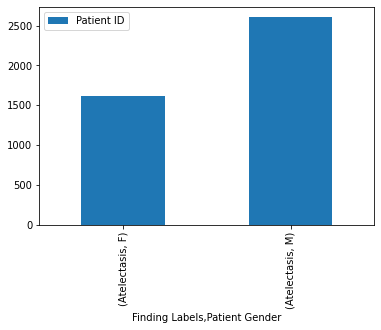

Patient ID
Finding Labels Patient Gender            
Atelectasis    F                     1612
               M                     2603

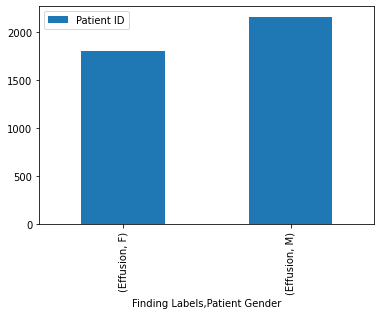

Patient ID
Finding Labels Patient Gender            
Effusion       F                     1797
               M                     2158

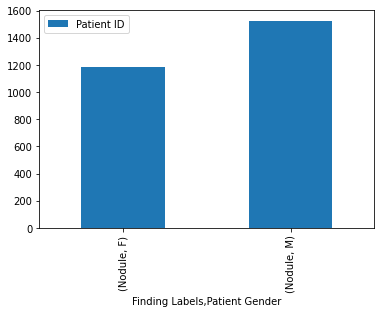

Patient ID
Finding Labels Patient Gender            
Nodule         F                     1181
               M                     1524

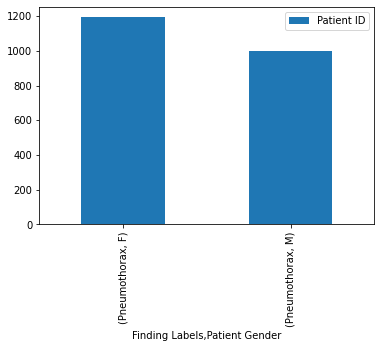

Patient ID
Finding Labels Patient Gender            
Pneumothorax   F                     1193
               M                     1001

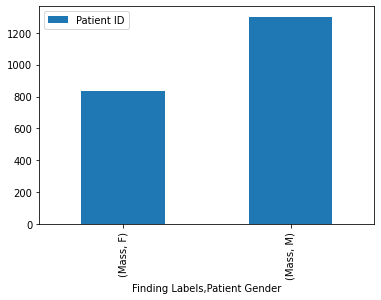

Patient ID
Finding Labels Patient Gender            
Mass           F                      838
               M                     1301

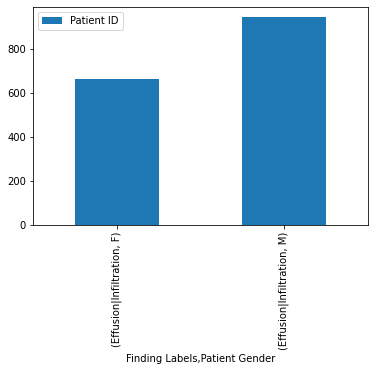

Patient ID
Finding Labels        Patient Gender            
Effusion|Infiltration F                      661
                      M                      942

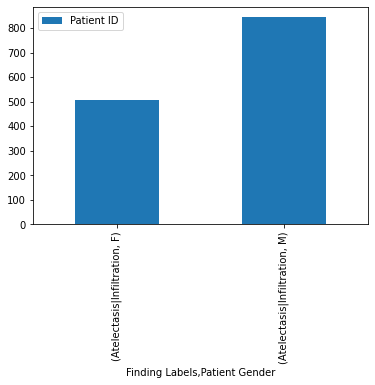

Patient ID
Finding Labels           Patient Gender            
Atelectasis|Infiltration F                      506
                         M                      844

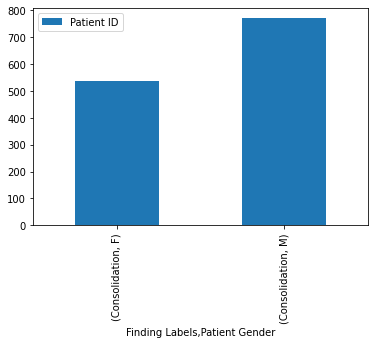

Patient ID
Finding Labels Patient Gender            
Consolidation  F                      539
               M                      771

In [ ]:
# посмотрим разбивку частых лейблов по полу

for label in common_labels:
    label_gender_pivot = (pd.pivot_table(data[data['finding labels'] == label], 
                          index = ['finding labels','patient gender'], 
                          values = 'patient id', 
                          aggfunc = 'count'))
    label_gender_pivot.plot(kind='bar')
    plt.show()
    display(label_gender_pivot)

In [ ]:
genders = data['patient gender'].value_counts()
genders

M    63340
F    48780
Name: patient gender, dtype: int64

In [ ]:
# сравним возраст больных и здоровых
healthy = data[data['finding labels'] == 'No Finding']
ill = data[data['finding labels'].isin(common_patology.index)]

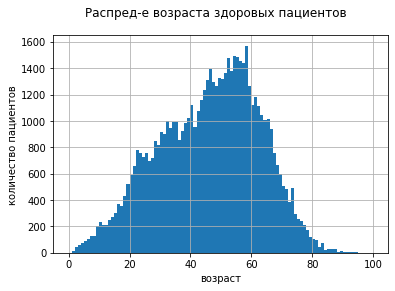

In [ ]:
healthy['patient age'].hist(bins=100, range=(0, 100))
plt.suptitle("Распред-е возраста здоровых пациентов")
plt.xlabel("возраст")
plt.ylabel("количество пациентов")
plt.show()

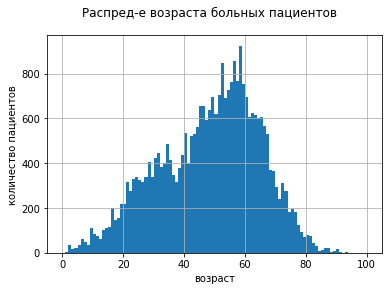

In [ ]:
ill['patient age'].hist(bins=100, range=(0, 100))
plt.suptitle("Распред-е возраста больных пациентов")
plt.xlabel("возраст")
plt.ylabel("количество пациентов")
plt.show()

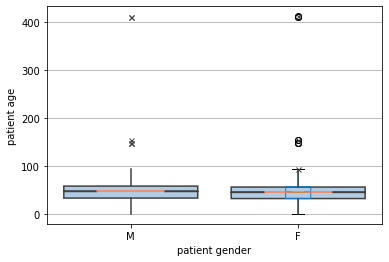

In [ ]:
# Сравним здоровых мужчин и женщин
healthy.boxplot(column='patient age', notch=True)
sns.boxplot(
    data=healthy, x="patient gender", y="patient age",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

### Выводы

*   Среди патологий самыми часто встречаемыми являются инфильтрация, эффузия и ателектаз.
*   Наибольшее число наблюдений характерно для пациентов без какой-либо патологии.
*   Среди патологических состояний выделяется, например, пневмоторакс, где количество наблюдений с этим лейблом больше у пациентов женского пола (в отличие от противоположной ситуации, когда количество пациентов мужского пола больше, характерной для большинства рассматриваемых патологий).



## Статистический анализ данных

Место для гипотезы

In [ ]:
'''one = data.query(' == ')[''].dropna()
display(one.describe())
two = data.query(' == ')[''].dropna()
display(two.describe())'''

In [ ]:
def stats(one):
    one_mean = one.mean()
    print('Среднее:', one_mean)
    one_var= np.var(one)
    print('Дисперсия:', one_var)
    one_std = np.sqrt(one_var)
    print('Стандартное отклонение:', one_std)
    one_most_val = one_mean + (one_std * 3)
    print('Большая часть значений в диапазоне от нуля до', one_most_val)
    sns.displot(one, discrete = True, kde = True)


In [ ]:
'''
# Например, т-тест
alpha = .01

results = st.ttest_ind(one, two)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
'''

Выводы

## Предобработка данных для построения модели

In [ ]:
data = data[:4999]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   image index                  4999 non-null   object 
 1   finding labels               4999 non-null   object 
 2   follow-up #                  4999 non-null   int64  
 3   patient id                   4999 non-null   int64  
 4   patient age                  4999 non-null   int64  
 5   patient gender               4999 non-null   object 
 6   view position                4999 non-null   object 
 7   originalimage[width          4999 non-null   int64  
 8   height]                      4999 non-null   int64  
 9   originalimagepixelspacing[x  4999 non-null   float64
 10  y]                           4999 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 429.7+ KB


In [ ]:
sample = random.sample(os.listdir(img_folder), 1000)

In [ ]:

def create_dataset(img_folder):
    img_data_array = []
    img_name = []
    for file in sample:
        image_path = os.path.join(img_folder, file)
        image = Image.open(image_path)
        sharpness = ImageEnhance.Sharpness(image)
        image = sharpness.enhance(100.0)
        brightness = ImageEnhance.Brightness(image)
        image = brightness.enhance(1.5)
        image = image.convert("1")
        #plt.imshow(image)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
        img_name.append(file)
    return img_data_array, img_name

# extract the image array and class name
img_data, img_name = create_dataset(r'/content/data/images_001/images')


In [ ]:
images_df = pd.DataFrame({'images':img_data, 'image index':img_name})

In [ ]:
data_merged = data.merge(images_df, how='inner', on='image index')

In [ ]:
display(data_merged.head())

,image index,finding labels,follow-up #,patient id,patient age,patient gender,view position,originalimage[width,height],originalimagepixelspacing[x,y],images
0,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"[[0.003921569, 0.003921569, 0.003921569, 0.003..."
1,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,"[[0.0, 0.003921569, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,0.143,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,0.143,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Выводы

## Общий вывод